## Unsupervised Learning Project

IMport all required libraries

In [55]:
%matplotlib inline

import numpy                    as    np
import pandas                   as    pd
import seaborn                  as    sns
import matplotlib.pyplot        as    plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm                import SVC
from sklearn.model_selection    import cross_val_score, train_test_split
from sklearn.preprocessing      import StandardScaler, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.decomposition      import PCA
from scipy.stats                import zscore
from sklearn.ensemble           import RandomForestClassifier
from sklearn.model_selection    import GridSearchCV 
from sklearn.metrics            import classification_report
import pandas_profiling         as     pp

Input Vehicle data and perform data exploratory analysis

In [70]:
Input  = pd.read_csv('ecoli.csv',names = 'mcg gvh lip chg aac alm1 alm2 class'.split(), sep = ',')
target = 'class'
df = Input.copy()

In [71]:
df.head()

,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


In [72]:
profile = df.profile_report(title='Pandas Profiling Report',html={'style':{'full_width':True}});
profile.to_file(output_file="Pandas_Profile_glass.html");
profile

Only target variable is in object, rest all are numerical format. This will save time because we need not to do any label encoding.

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mcg     336 non-null    float64
 1   gvh     336 non-null    float64
 2   lip     336 non-null    float64
 3   chg     336 non-null    float64
 4   aac     336 non-null    float64
 5   alm1    336 non-null    float64
 6   alm2    336 non-null    float64
 7   class   336 non-null    object 
dtypes: float64(7), object(1)
memory usage: 21.1+ KB


18 features and 846 rows. Featues are having varied means and standard deviation, so we need to do scaling of the data.

In [74]:
print(df.shape)
df.describe()

(336, 8)


,mcg,gvh,lip,chg,aac,alm1,alm2
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,0.500060,0.500000,0.495476,0.501488,0.500030,0.500179,0.499732
std,0.194634,0.148157,0.088495,0.027277,0.122376,0.215751,0.209411
min,0.000000,0.160000,0.480000,0.500000,0.000000,0.030000,0.000000
25%,0.340000,0.400000,0.480000,0.500000,0.420000,0.330000,0.350000
50%,0.500000,0.470000,0.480000,0.500000,0.495000,0.455000,0.430000
75%,0.662500,0.570000,0.480000,0.500000,0.570000,0.710000,0.710000
max,0.890000,1.000000,1.000000,1.000000,0.880000,1.000000,0.990000


There are no null values.

In [75]:
df.isnull().sum()

mcg      0
gvh      0
lip      0
chg      0
aac      0
alm1     0
alm2     0
class    0
dtype: int64

As per the pair plot there are correlated features. Also some of the features are skewed and having outliers. So we probably need to do find and remove outliers, try log transformation and remove outliers.

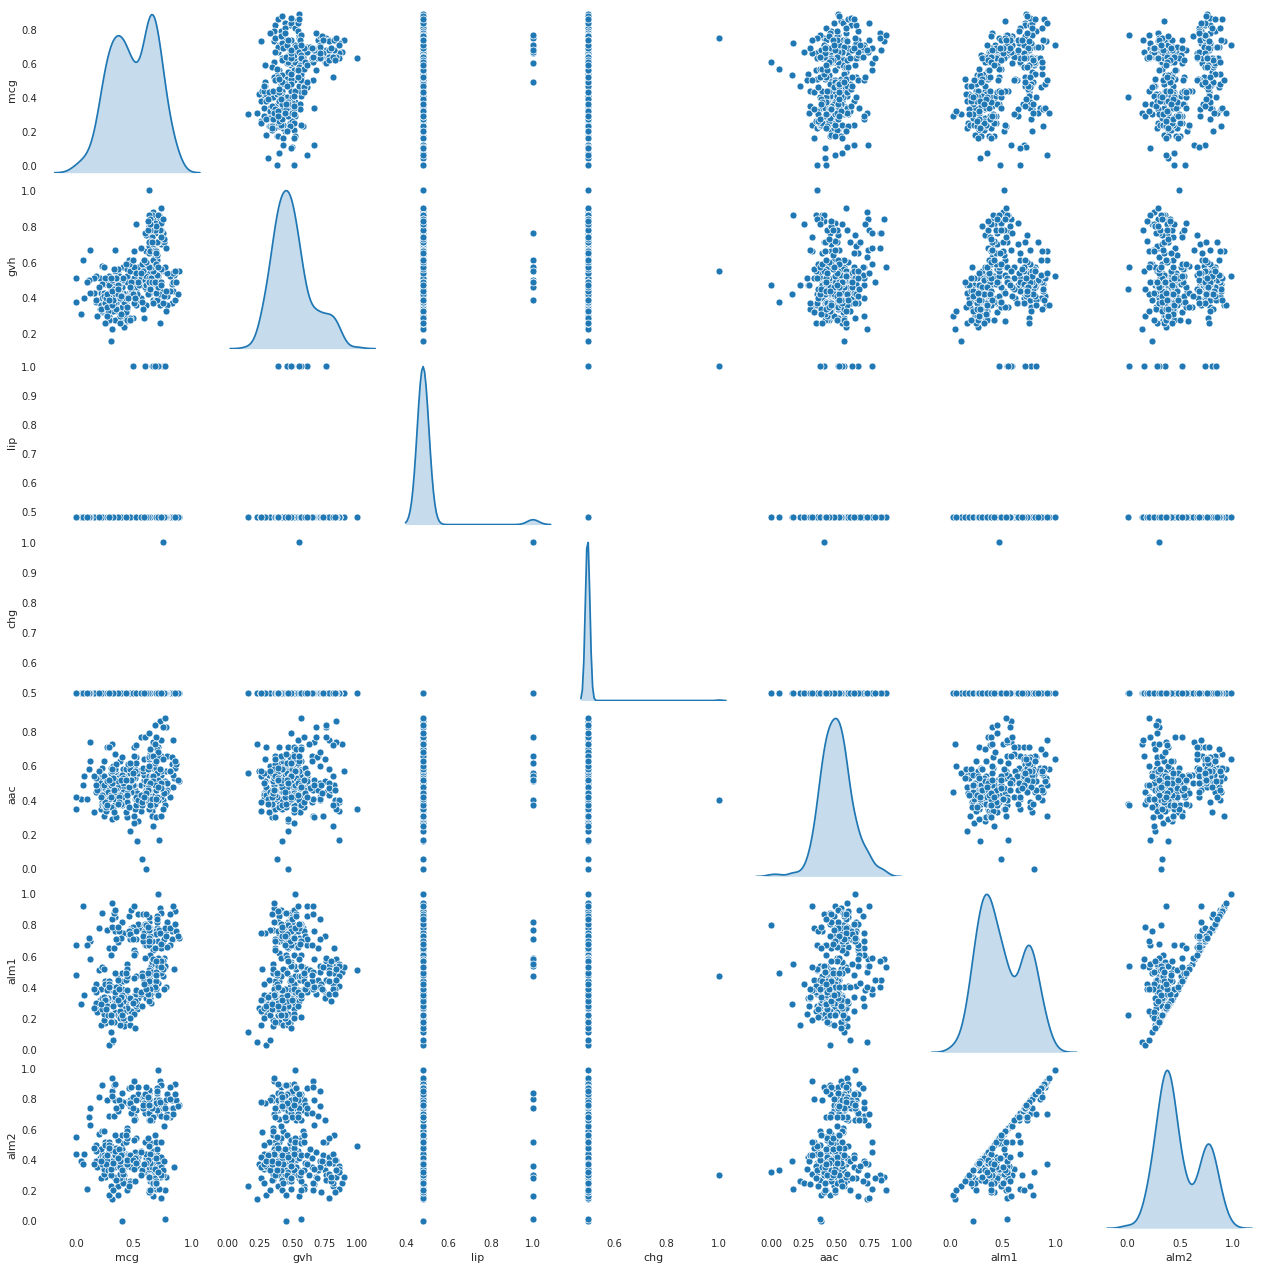

In [76]:
sns.pairplot(df,diag_kind = 'kde')

Below chart give us idea of the order of feature importance.

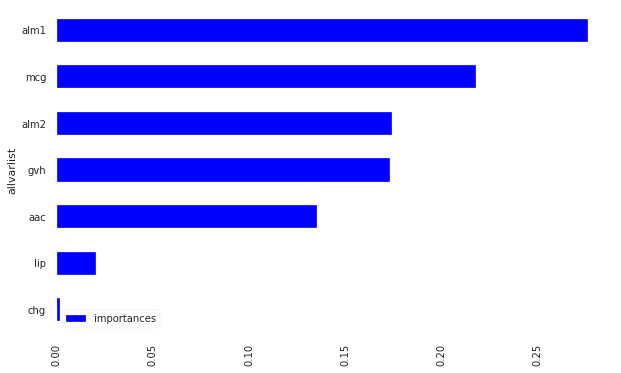

In [77]:
model     = RandomForestClassifier()
df        = Input.copy()
df        .fillna(df.median(),inplace = True)
X         = df.drop(target, axis = 1)
y         = df[target]
model.fit(X, y)

df_importance=pd.DataFrame({'allvarlist':X.columns,'importances':model.feature_importances_})
df_importance.sort_values('importances',inplace=True)

df_importance.plot(kind='barh',y='importances',x='allvarlist',color='b',figsize=(10,6))

plt.xticks(rotation = 90)
plt.show()

Heat map shows there are numbers of highly correlated columns. We will keep of cut-off of 0.9 and try to remove correlated columns. We will try to keep hig importance columns at the same time remove correlated columns.

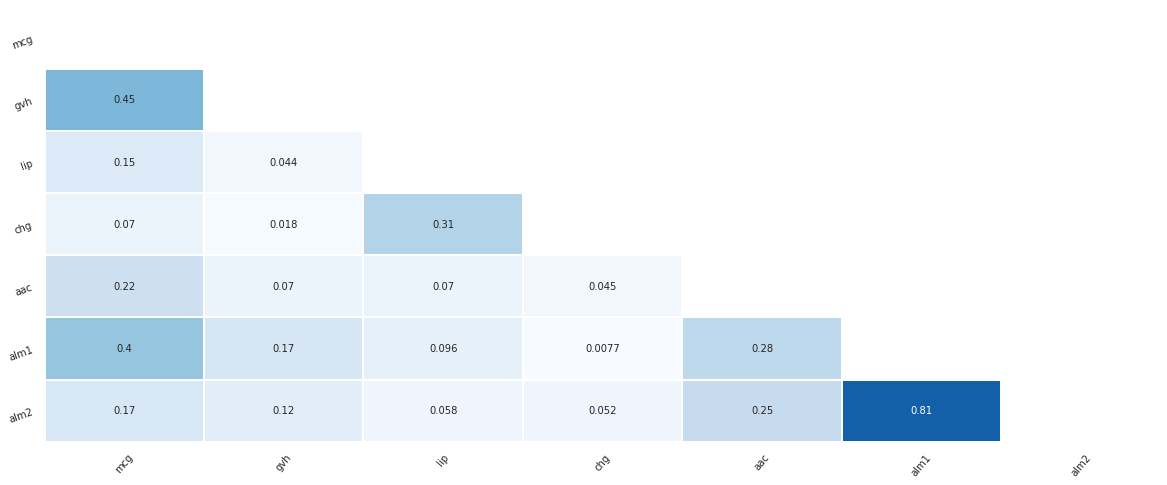

In [78]:
corr = abs(df.corr()) # correlation matrix
lower_triangle = np.tril(corr, k = -1)  # select only the lower triangle of the correlation matrix
mask = lower_triangle == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (20,8))  # setting the figure size
sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines
sns.heatmap(lower_triangle, center=0.5, cmap= 'Blues', annot= True, xticklabels = corr.index, yticklabels = corr.columns,
            cbar= False, linewidths= 1, mask = mask)   # Da Heatmap
plt.xticks(rotation = 50)   # Aesthetic purposes
plt.yticks(rotation = 20)   # Aesthetic purposes
plt.show()

Here we can see the high coorelation values from where we can pick correlated columns.

In [79]:
df.corr().unstack().sort_values().drop_duplicates().nlargest(20).reset_index().iloc[:20,:]

,level_0,level_1,0
0,mcg,mcg,1.000000
1,alm1,alm2,0.809324
2,gvh,mcg,0.454805
3,alm1,mcg,0.396979
4,chg,lip,0.311951
5,aac,alm1,0.279482
6,alm2,aac,0.252675
7,mcg,aac,0.220699
8,gvh,alm1,0.173492
9,alm2,mcg,0.167086


In [80]:
df.corr().unstack().sort_values().drop_duplicates().nlargest(20).reset_index().iloc[:10,:]

,level_0,level_1,0
0,mcg,mcg,1.000000
1,alm1,alm2,0.809324
2,gvh,mcg,0.454805
3,alm1,mcg,0.396979
4,chg,lip,0.311951
5,aac,alm1,0.279482
6,alm2,aac,0.252675
7,mcg,aac,0.220699
8,gvh,alm1,0.173492
9,alm2,mcg,0.167086


We will pick below six features and remove them to get rid of correlated features.

In [81]:
df.corr().unstack().sort_values().drop_duplicates().nlargest(20).reset_index().iloc[1:2,:]['level_0'].drop_duplicates().to_list()

['alm1']

In [84]:
drop_cols = []

After removing those six columns, here is the feature importance chart.

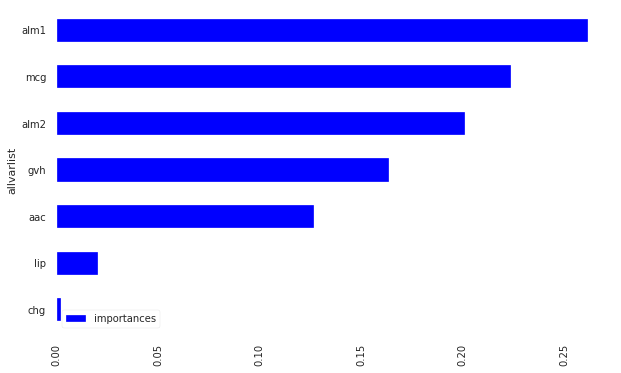

In [85]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

df = Input.copy()
df.fillna(df.median(),inplace = True)
#high_corr_cols = ['scaled_variance.1',  'pr.axis_rectangularity',  'circularity', 'scatter_ratio', 'scaled_variance', 'distance_circularity']
df = df.drop(drop_cols, axis = 1)

X = df.drop(target, axis = 1)
y = df[target]
model.fit(X, y)

df_importance=pd.DataFrame({'allvarlist':X.columns,'importances':model.feature_importances_})
df_importance.sort_values('importances',inplace=True)

df_importance.plot(kind='barh',y='importances',x='allvarlist',color='b',figsize=(10,6))

plt.xticks(rotation = 90)
plt.show()

Heat map is much cleaner now.

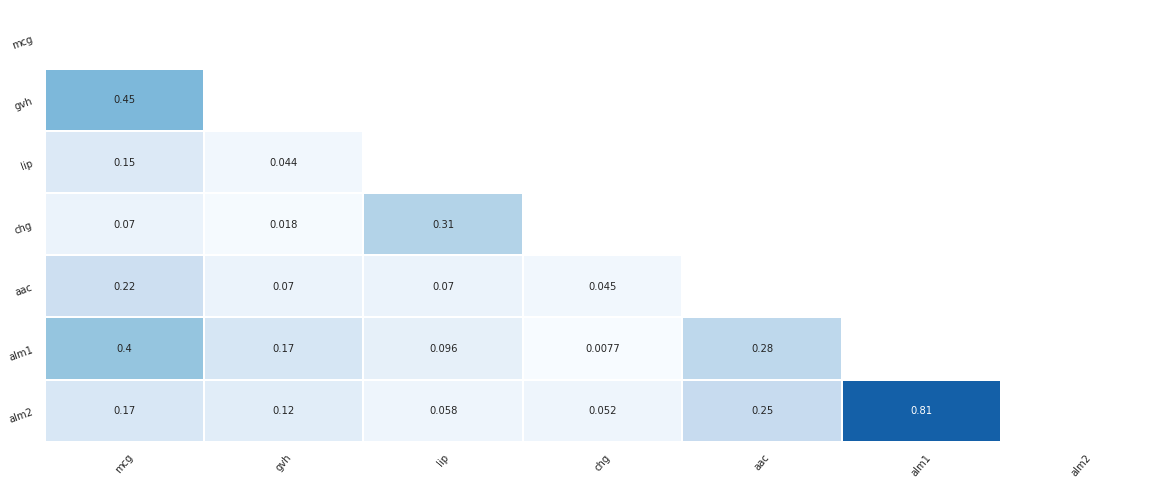

In [86]:
df = Input.copy()
df.fillna(df.median(),inplace = True)

df = df.drop(drop_cols, axis = 1)

corr = abs(df.corr()) # correlation matrix
lower_triangle = np.tril(corr, k = -1)  # select only the lower triangle of the correlation matrix
mask = lower_triangle == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (20,8))  # setting the figure size
sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines
sns.heatmap(lower_triangle, center=0.5, cmap= 'Blues', annot= True, xticklabels = corr.index, yticklabels = corr.columns,
            cbar= False, linewidths= 1, mask = mask)   # Da Heatmap
plt.xticks(rotation = 50)   # Aesthetic purposes
plt.yticks(rotation = 20)   # Aesthetic purposes
plt.show()

Creating SVM model and trying various scenarios.

Below definition will perform traintrain, test split and also provide train, test and crossvalidation scores. We will be calling below function agaian and again to check results.

In [87]:
def svm_scorer(model,X,y):

    X_train,X_test, y_train, y_test = train_test_split(X,y, random_state = 1)
    model.fit(X_train,y_train)
    train_score                     = model.score(X_train,y_train)                 .round(5)
    test_score                      = model.score(X_test,y_test)                   .round(5)
    cval_scores                     = np   .abs(cross_val_score(model, X, y, cv=10)).round(3) 
    cval_scores_mean                = cval_scores.mean()                           .round(5)

    return type(model).__name__,X.shape,train_score, test_score, cval_scores, cval_scores_mean

we will maintain results in various in a dataframe for comparison purpose.

In [88]:
df_result = {}

##### Fillna with mean

In [89]:
Input.head()

,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


In [90]:
df                        = Input.copy()
df                        .fillna(df.mean(),inplace = True)
X                         = df.drop([target], axis = 1)
y                         = df[target]
transformation            = 'Fillna with mean' 
model                     = SVC()
df_result[transformation] = svm_scorer(model,X,y)

In [91]:
df_result_main            = pd.DataFrame(np.array(list(df_result.values()))[:,0:6], columns= ['Model','Features_shape', 'Train_Score','Test_Score','Cross_Validation_Scores','Mean_Cross_Validation_Scores'], index= df_result.keys())   
df_result_main.index.name = 'Model'  
df_result_main.style.set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,Model,Features_shape,Train_Score,Test_Score,Cross_Validation_Scores,Mean_Cross_Validation_Scores
Model,,,,,,
Fillna with mean,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100


##### Fillna with median

In [92]:
df                        = Input.copy()
df                        .fillna(df.median(),inplace = True)
X                         = df.drop([target], axis = 1)
y                         = df[target]
transformation            = 'Fillna with median' 
model                     = SVC()
df_result[transformation] = svm_scorer(model,X,y)

In [93]:
df_result_main            = pd.DataFrame(np.array(list(df_result.values()))[:,0:6], columns= ['Model','Features_shape', 'Train_Score','Test_Score','Cross_Validation_Scores','Mean_Cross_Validation_Scores'], index= df_result.keys())   
df_result_main.index.name = 'Model'  
df_result_main.style.set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,Model,Features_shape,Train_Score,Test_Score,Cross_Validation_Scores,Mean_Cross_Validation_Scores
Model,,,,,,
Fillna with mean,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna with median,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100


There is very less difference in accuracy for mean and median options. However, considering there are outliers we will go ahead with median for rest of the analysis.

##### Fillna_median -> Standard_Scaler

In [94]:
df                        = Input.copy()
df                        .fillna(df.median(),inplace = True)
X                         = df.drop([target], axis = 1)
y                         = df[target]
scl                       = StandardScaler()
X_scaled                  = scl.fit_transform(X) 
transformation            = 'Fillna_median -> Standard_Scaler' 
model                     = SVC()
df_result[transformation] = svm_scorer(model,X_scaled,y)

In [95]:
df_result_main            = pd.DataFrame(np.array(list(df_result.values()))[:,0:6], columns= ['Model','Features_shape', 'Train_Score','Test_Score','Cross_Validation_Scores','Mean_Cross_Validation_Scores'], index= df_result.keys())   
df_result_main.index.name = 'Model'  
df_result_main.style.set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,Model,Features_shape,Train_Score,Test_Score,Cross_Validation_Scores,Mean_Cross_Validation_Scores
Model,,,,,,
Fillna with mean,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna with median,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna_median -> Standard_Scaler,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000


Accuracy jumped to 96 percent after performing standard scaling on the data.

##### Fillna_median -> Min_Max_Scaler

In [96]:
df                        = Input.copy()
df                        .fillna(df.median(),inplace = True)
X                         = df.drop([target], axis = 1)
y                         = df[target]
scl                       = MinMaxScaler()
X_scaled                  = scl.fit_transform(X) 
transformation            = 'Fillna_median -> Min_Max_Scaler' 
model                     = SVC()
df_result[transformation] = svm_scorer(model,X_scaled,y)

In [97]:
df_result_main            = pd.DataFrame(np.array(list(df_result.values()))[:,0:6], columns= ['Model','Features_shape', 'Train_Score','Test_Score','Cross_Validation_Scores','Mean_Cross_Validation_Scores'], index= df_result.keys())   
df_result_main.index.name = 'Model'  
df_result_main.style.set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,Model,Features_shape,Train_Score,Test_Score,Cross_Validation_Scores,Mean_Cross_Validation_Scores
Model,,,,,,
Fillna with mean,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna with median,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna_median -> Standard_Scaler,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Min_Max_Scaler,SVC,"(336, 7)",0.884920,0.892860,[0.941 0.912 0.853 0.824 0.912 0.735 0.848 0.879 0.879 0.788],0.857100


Standard scaler seems to work better in our case.

##### Fillna_median -> Standard_Scaler -> Remove_corr_vars

In [98]:
df                        = Input.copy()
df                        .fillna(df.median(),inplace = True)
high_corr_cols            = ['scaled_variance.1',  'pr.axis_rectangularity',  'circularity', 'scatter_ratio', 'scaled_variance', 'distance_circularity']
df                        = df.drop(drop_cols, axis = 1)
X                         = df.drop([target], axis = 1)
y                         = df[target]
scl                       = StandardScaler()
X_scaled                  = scl.fit_transform(X) 
transformation            = 'Fillna_median -> Standard_Scaler -> Remove_corr_vars' 
model                     = SVC()
df_result[transformation] = svm_scorer(model,X_scaled,y)

In [99]:
df_result_main            = pd.DataFrame(np.array(list(df_result.values()))[:,0:6], columns= ['Model','Features_shape', 'Train_Score','Test_Score','Cross_Validation_Scores','Mean_Cross_Validation_Scores'], index= df_result.keys())   
df_result_main.index.name = 'Model'  
df_result_main.style.set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,Model,Features_shape,Train_Score,Test_Score,Cross_Validation_Scores,Mean_Cross_Validation_Scores
Model,,,,,,
Fillna with mean,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna with median,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna_median -> Standard_Scaler,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Min_Max_Scaler,SVC,"(336, 7)",0.884920,0.892860,[0.941 0.912 0.853 0.824 0.912 0.735 0.848 0.879 0.879 0.788],0.857100
Fillna_median -> Standard_Scaler -> Remove_corr_vars,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000


After removing highly correlated columns, the accuracy remain almost same.

##### Fillna_median -> Standard_Scaler -> Remove_corr_vars -> Poly_features

In [100]:
df                        = Input.copy()
df                        .fillna(df.median(),inplace = True)
df                        = df.drop(drop_cols, axis = 1)
X                         = df.drop([target], axis = 1)
y                         = df[target]
scl                       = StandardScaler()
X_scaled                  = scl.fit_transform(X) 
poly                      = PolynomialFeatures(interaction_only = True)
X_poly                    = poly.fit_transform(X_scaled)
transformation            = 'Fillna_median -> Standard_Scaler -> Remove_corr_vars -> Poly_features' 
model                     = SVC()
df_result[transformation] = svm_scorer(model,X_poly,y)

In [101]:
df_result_main            = pd.DataFrame(np.array(list(df_result.values()))[:,0:6], columns= ['Model','Features_shape', 'Train_Score','Test_Score','Cross_Validation_Scores','Mean_Cross_Validation_Scores'], index= df_result.keys())   
df_result_main.index.name = 'Model'  
df_result_main.style.set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,Model,Features_shape,Train_Score,Test_Score,Cross_Validation_Scores,Mean_Cross_Validation_Scores
Model,,,,,,
Fillna with mean,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna with median,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna_median -> Standard_Scaler,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Min_Max_Scaler,SVC,"(336, 7)",0.884920,0.892860,[0.941 0.912 0.853 0.824 0.912 0.735 0.848 0.879 0.879 0.788],0.857100
Fillna_median -> Standard_Scaler -> Remove_corr_vars,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Standard_Scaler -> Remove_corr_vars -> Poly_features,SVC,"(336, 29)",0.865080,0.904760,[0.882 0.882 0.853 0.824 0.853 0.735 0.879 0.879 0.879 0.758],0.842400


Polynomial features seems to have a negative impact on accuracy.

##### Fillna_median -> Standard_Scaler -> Remove_corr_vars -> MinMaxScaler -> Log -> Z-Score -> Outlier_Removal

In [102]:
df                        = Input.copy()
df                        .fillna(df.median(),inplace = True)
df                        = df.drop(drop_cols, axis = 1)
X                         = df.drop([target], axis = 1)
y                         = df[target]
scl                       = MinMaxScaler(feature_range = (0.1,1))
X_scaled                  = pd.DataFrame(scl.fit_transform(X), columns = X.columns)
X_log                     = pd.DataFrame(np.log10(X_scaled), columns = X.columns)
X_zscore                  = X_log.apply(zscore)
df_zscore                 = pd.concat([X_zscore,y], axis = 1)
df_zscore_rem             = df_zscore[(np.abs(X_zscore) < 3).all(axis=1)]
X_zscore_rem              = df_zscore_rem.drop([target], axis = 1)
y_zscore_rem              = df_zscore_rem[target]
transformation            = 'Fillna_median -> Standard_Scaler -> Remove_corr_vars -> MinMaxScaler -> Log -> Z-Score -> Outlier_Removal' 
model                     = SVC()
df_result[transformation] = svm_scorer(model,X_zscore_rem,y_zscore_rem)

In [103]:
df_result_main            = pd.DataFrame(np.array(list(df_result.values()))[:,0:6], columns= ['Model','Features_shape', 'Train_Score','Test_Score','Cross_Validation_Scores','Mean_Cross_Validation_Scores'], index= df_result.keys())   
df_result_main.index.name = 'Model'  
df_result_main.style.set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,Model,Features_shape,Train_Score,Test_Score,Cross_Validation_Scores,Mean_Cross_Validation_Scores
Model,,,,,,
Fillna with mean,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna with median,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna_median -> Standard_Scaler,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Min_Max_Scaler,SVC,"(336, 7)",0.884920,0.892860,[0.941 0.912 0.853 0.824 0.912 0.735 0.848 0.879 0.879 0.788],0.857100
Fillna_median -> Standard_Scaler -> Remove_corr_vars,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Standard_Scaler -> Remove_corr_vars -> Poly_features,SVC,"(336, 29)",0.865080,0.904760,[0.882 0.882 0.853 0.824 0.853 0.735 0.879 0.879 0.879 0.758],0.842400
Fillna_median -> Standard_Scaler -> Remove_corr_vars -> MinMaxScaler -> Log -> Z-Score -> Outlier_Removal,SVC,"(312, 7)",0.905980,0.858970,[0.938 0.906 0.839 0.903 0.839 0.806 0.871 0.871 0.839 0.806],0.861800


After remving outliers, accuracy remain almost same. So we will go ahead with outlier removal because tha will give us more generalised model for prediction.

Pair plot look more clean after outlier and correlated columns removal.

LinAlgError: singular matrix

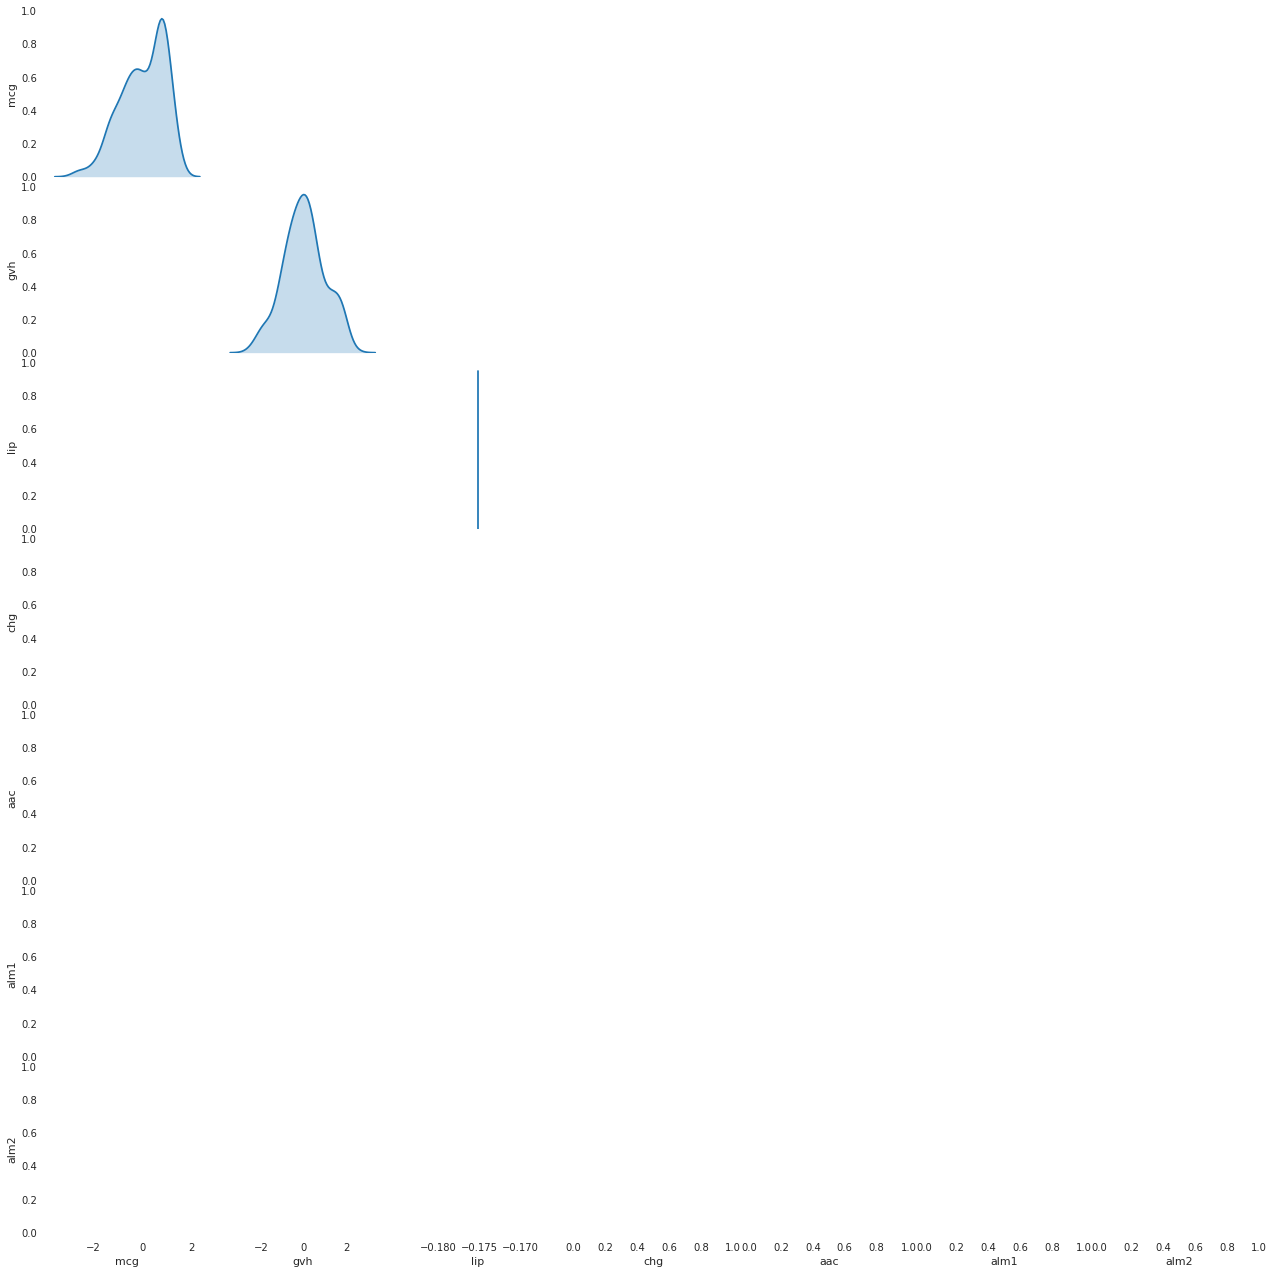

In [104]:
sns.pairplot(X_zscore_rem, diag_kind = 'kde')

##### Fillna_median -> Standard_Scaler -> Remove_corr_vars - > PCA 7

In [105]:
df                        = Input.copy()
df                        .fillna(df.median(),inplace = True)
df                        = df.drop(drop_cols, axis = 1)
X                         = df.drop([target], axis = 1)
y                         = df[target]
scl                       = StandardScaler()
X_scaled                  = scl.fit_transform(X) 
pca_dim                   = 6
pca                       = PCA(n_components = pca_dim)
X_pca                     = pd.DataFrame(pca.fit_transform(X_scaled))
transformation            = 'Fillna_median -> Standard_Scaler -> Remove_corr_vars - > PCA ' +  str(pca_dim)
model                     = SVC()
df_result[transformation] = svm_scorer(model,X_pca,y)

[0.31508933 0.52383085 0.6954741  0.8179254  0.91356006 0.98193951]


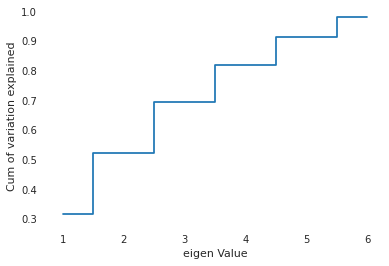

In [106]:
print(np.cumsum(pca.explained_variance_ratio_))

plt.step(list(range(1,pca_dim + 1)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

In [107]:
df_result_main            = pd.DataFrame(np.array(list(df_result.values()))[:,0:6], columns= ['Model','Features_shape', 'Train_Score','Test_Score','Cross_Validation_Scores','Mean_Cross_Validation_Scores'], index= df_result.keys())   
df_result_main.index.name = 'Model'  
df_result_main.style.set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,Model,Features_shape,Train_Score,Test_Score,Cross_Validation_Scores,Mean_Cross_Validation_Scores
Model,,,,,,
Fillna with mean,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna with median,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna_median -> Standard_Scaler,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Min_Max_Scaler,SVC,"(336, 7)",0.884920,0.892860,[0.941 0.912 0.853 0.824 0.912 0.735 0.848 0.879 0.879 0.788],0.857100
Fillna_median -> Standard_Scaler -> Remove_corr_vars,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Standard_Scaler -> Remove_corr_vars -> Poly_features,SVC,"(336, 29)",0.865080,0.904760,[0.882 0.882 0.853 0.824 0.853 0.735 0.879 0.879 0.879 0.758],0.842400
Fillna_median -> Standard_Scaler -> Remove_corr_vars -> MinMaxScaler -> Log -> Z-Score -> Outlier_Removal,SVC,"(312, 7)",0.905980,0.858970,[0.938 0.906 0.839 0.903 0.839 0.806 0.871 0.871 0.839 0.806],0.861800
Fillna_median -> Standard_Scaler -> Remove_corr_vars - > PCA 6,SVC,"(336, 6)",0.884920,0.892860,[0.941 0.912 0.853 0.794 0.912 0.765 0.848 0.879 0.848 0.818],0.857000


PCA with 7 components will capture 95 percent of the data variance. Accuracy went down to 90.5 percent. However the model is mor simplified with only 7 feature columns. This will be an advantage in terms of speed and probably save the model from over fitting.

##### Fillna_median -> Standard_Scaler -> Remove_corr_vars - > PCA 8

In [108]:
df                        = Input.copy()
df                        .fillna(df.median(),inplace = True)
df                        = df.drop(drop_cols, axis = 1)
X                         = df.drop([target], axis = 1)
y                         = df[target]
scl                       = StandardScaler()
X_scaled                  = scl.fit_transform(X) 
pca_dim                   = 4
pca                       = PCA(n_components = pca_dim)
X_pca                     = pd.DataFrame(pca.fit_transform(X_scaled))
transformation            = 'Fillna_median -> Standard_Scaler -> Remove_corr_vars - > PCA ' +  str(pca_dim)
model                     = SVC()
df_result[transformation] = svm_scorer(model,X_pca,y)

[0.31508933 0.52383085 0.6954741  0.8179254 ]


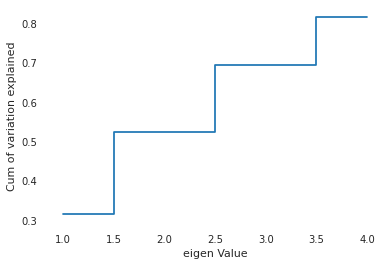

In [109]:
print(np.cumsum(pca.explained_variance_ratio_))

plt.step(list(range(1,pca_dim + 1)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

In [110]:
df_result_main            = pd.DataFrame(np.array(list(df_result.values()))[:,0:6], columns= ['Model','Features_shape', 'Train_Score','Test_Score','Cross_Validation_Scores','Mean_Cross_Validation_Scores'], index= df_result.keys())   
df_result_main.index.name = 'Model'  
df_result_main.style.set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,Model,Features_shape,Train_Score,Test_Score,Cross_Validation_Scores,Mean_Cross_Validation_Scores
Model,,,,,,
Fillna with mean,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna with median,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna_median -> Standard_Scaler,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Min_Max_Scaler,SVC,"(336, 7)",0.884920,0.892860,[0.941 0.912 0.853 0.824 0.912 0.735 0.848 0.879 0.879 0.788],0.857100
Fillna_median -> Standard_Scaler -> Remove_corr_vars,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Standard_Scaler -> Remove_corr_vars -> Poly_features,SVC,"(336, 29)",0.865080,0.904760,[0.882 0.882 0.853 0.824 0.853 0.735 0.879 0.879 0.879 0.758],0.842400
Fillna_median -> Standard_Scaler -> Remove_corr_vars -> MinMaxScaler -> Log -> Z-Score -> Outlier_Removal,SVC,"(312, 7)",0.905980,0.858970,[0.938 0.906 0.839 0.903 0.839 0.806 0.871 0.871 0.839 0.806],0.861800
Fillna_median -> Standard_Scaler -> Remove_corr_vars - > PCA 6,SVC,"(336, 6)",0.884920,0.892860,[0.941 0.912 0.853 0.794 0.912 0.765 0.848 0.879 0.848 0.818],0.857000
Fillna_median -> Standard_Scaler -> Remove_corr_vars - > PCA 4,SVC,"(336, 4)",0.833330,0.880950,[0.824 0.853 0.853 0.824 0.882 0.765 0.788 0.818 0.788 0.697],0.809200


Out of curosity when I tried with PCA 8 which capture 97.5 percent of data variance, our accuracy jumped to .95

##### Fillna_median -> Standard_Scaler -> Remove_corr_vars -> Poly_features -> PCA 7

In [111]:
df                        = Input.copy()
df                        .fillna(df.median(),inplace = True)
df                        = df.drop(drop_cols, axis = 1)
X                         = df.drop([target], axis = 1)
y                         = df[target]
scl                       = StandardScaler()
X_scaled                  = scl.fit_transform(X) 
poly                      = PolynomialFeatures(interaction_only = True)
X_poly                    = poly.fit_transform(X_scaled)
pca_dim                   = 10
pca                       = PCA(n_components = pca_dim)
X_pca                     = pd.DataFrame(pca.fit_transform(X_poly))
transformation            = 'Fillna_median -> Standard_Scaler -> Remove_corr_vars -> Poly_features -> PCA ' +  str(pca_dim)
model                     = SVC()
df_result[transformation] = svm_scorer(model,X_pca,y)

[0.65842268 0.71256114 0.76009453 0.80290846 0.84176417 0.87254363
 0.89592607 0.9181732  0.93354419 0.94727983]


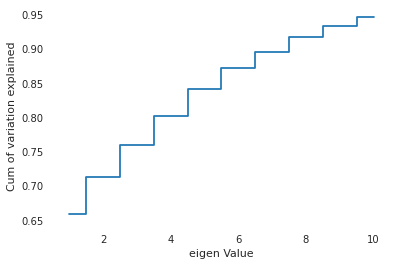

In [112]:
print(np.cumsum(pca.explained_variance_ratio_))

plt.step(list(range(1,pca_dim + 1)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

In [113]:
df_result_main            = pd.DataFrame(np.array(list(df_result.values()))[:,0:6], columns= ['Model','Features_shape', 'Train_Score','Test_Score','Cross_Validation_Scores','Mean_Cross_Validation_Scores'], index= df_result.keys())   
df_result_main.index.name = 'Model'  
df_result_main.style.set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,Model,Features_shape,Train_Score,Test_Score,Cross_Validation_Scores,Mean_Cross_Validation_Scores
Model,,,,,,
Fillna with mean,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna with median,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna_median -> Standard_Scaler,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Min_Max_Scaler,SVC,"(336, 7)",0.884920,0.892860,[0.941 0.912 0.853 0.824 0.912 0.735 0.848 0.879 0.879 0.788],0.857100
Fillna_median -> Standard_Scaler -> Remove_corr_vars,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Standard_Scaler -> Remove_corr_vars -> Poly_features,SVC,"(336, 29)",0.865080,0.904760,[0.882 0.882 0.853 0.824 0.853 0.735 0.879 0.879 0.879 0.758],0.842400
Fillna_median -> Standard_Scaler -> Remove_corr_vars -> MinMaxScaler -> Log -> Z-Score -> Outlier_Removal,SVC,"(312, 7)",0.905980,0.858970,[0.938 0.906 0.839 0.903 0.839 0.806 0.871 0.871 0.839 0.806],0.861800
Fillna_median -> Standard_Scaler -> Remove_corr_vars - > PCA 6,SVC,"(336, 6)",0.884920,0.892860,[0.941 0.912 0.853 0.794 0.912 0.765 0.848 0.879 0.848 0.818],0.857000
Fillna_median -> Standard_Scaler -> Remove_corr_vars - > PCA 4,SVC,"(336, 4)",0.833330,0.880950,[0.824 0.853 0.853 0.824 0.882 0.765 0.788 0.818 0.788 0.697],0.809200


PCA along with PCA seems not to do good job.

##### Fillna_median -> Standard_Scaler -> Remove_corr_vars ->  PCA 7 -> Poly_features

In [114]:
df                        = Input.copy()
df                        .fillna(df.median(),inplace = True)
df                        = df.drop(drop_cols, axis = 1)
X                         = df.drop([target], axis = 1)
y                         = df[target]
scl                       = StandardScaler()
X_scaled                  = scl.fit_transform(X) 
pca_dim                   = 3
pca                       = PCA(n_components = pca_dim)
X_pca                     = pd.DataFrame(pca.fit_transform(X_scaled))
poly                      = PolynomialFeatures(interaction_only = True)
X_poly                    = poly.fit_transform(X_pca)
transformation            = 'Fillna_median -> Standard_Scaler -> Remove_corr_vars ->  PCA ' +  str(pca_dim) + ' -> Poly_features' 
model                     = SVC()
df_result[transformation] = svm_scorer(model,X_poly,y)

[0.31508933 0.52383085 0.6954741 ]


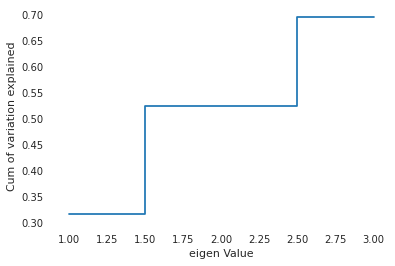

In [115]:
print(np.cumsum(pca.explained_variance_ratio_))

plt.step(list(range(1,pca_dim + 1)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

In [116]:
df_result_main            = pd.DataFrame(np.array(list(df_result.values()))[:,0:6], columns= ['Model','Features_shape', 'Train_Score','Test_Score','Cross_Validation_Scores','Mean_Cross_Validation_Scores'], index= df_result.keys())   
df_result_main.index.name = 'Model'  
df_result_main.style.set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,Model,Features_shape,Train_Score,Test_Score,Cross_Validation_Scores,Mean_Cross_Validation_Scores
Model,,,,,,
Fillna with mean,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna with median,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna_median -> Standard_Scaler,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Min_Max_Scaler,SVC,"(336, 7)",0.884920,0.892860,[0.941 0.912 0.853 0.824 0.912 0.735 0.848 0.879 0.879 0.788],0.857100
Fillna_median -> Standard_Scaler -> Remove_corr_vars,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Standard_Scaler -> Remove_corr_vars -> Poly_features,SVC,"(336, 29)",0.865080,0.904760,[0.882 0.882 0.853 0.824 0.853 0.735 0.879 0.879 0.879 0.758],0.842400
Fillna_median -> Standard_Scaler -> Remove_corr_vars -> MinMaxScaler -> Log -> Z-Score -> Outlier_Removal,SVC,"(312, 7)",0.905980,0.858970,[0.938 0.906 0.839 0.903 0.839 0.806 0.871 0.871 0.839 0.806],0.861800
Fillna_median -> Standard_Scaler -> Remove_corr_vars - > PCA 6,SVC,"(336, 6)",0.884920,0.892860,[0.941 0.912 0.853 0.794 0.912 0.765 0.848 0.879 0.848 0.818],0.857000
Fillna_median -> Standard_Scaler -> Remove_corr_vars - > PCA 4,SVC,"(336, 4)",0.833330,0.880950,[0.824 0.853 0.853 0.824 0.882 0.765 0.788 0.818 0.788 0.697],0.809200


Even if we change the order first PCA and then Polynomial features, accuracy remain low. 

##### Fillna_median -> Standard_Scaler -> Remove_corr_vars -> MinMaxScaler -> Log -> Z-Score -> Outlier_Removal -> PCA 7

In [117]:
df                        = Input.copy()
df                        .fillna(df.median(),inplace = True)
df                        = df.drop(drop_cols, axis = 1)
X                         = df.drop([target], axis = 1)
y                         = df[target]
scl                       = MinMaxScaler(feature_range = (0.1,1))
X_scaled                  = pd.DataFrame(scl.fit_transform(X), columns = X.columns)
X_log                     = pd.DataFrame(np.log10(X_scaled), columns = X.columns)
X_zscore                  = X_log.apply(zscore)
df_zscore                 = pd.concat([X_zscore,y], axis = 1)
df_zscore_rem             = df_zscore[(np.abs(X_zscore) < 3).all(axis=1)]
X_zscore_rem              = df_zscore_rem.drop([target], axis = 1)
y_zscore_rem              = df_zscore_rem[target]
pca_dim                   = 3
pca                       = PCA(n_components = pca_dim)
X_pca                     = pd.DataFrame(pca.fit_transform(X_zscore_rem))
transformation            = 'Fillna_median -> Standard_Scaler -> Remove_corr_vars -> MinMaxScaler -> Log -> Z-Score -> Outlier_Removal -> PCA ' +  str(pca_dim)
model                     = SVC()
df_result[transformation] = svm_scorer(model,X_pca,y_zscore_rem)

In [118]:
df_result_main            = pd.DataFrame(np.array(list(df_result.values()))[:,0:6], columns= ['Model','Features_shape', 'Train_Score','Test_Score','Cross_Validation_Scores','Mean_Cross_Validation_Scores'], index= df_result.keys())   
df_result_main.index.name = 'Model'  
df_result_main.style.set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,Model,Features_shape,Train_Score,Test_Score,Cross_Validation_Scores,Mean_Cross_Validation_Scores
Model,,,,,,
Fillna with mean,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna with median,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna_median -> Standard_Scaler,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Min_Max_Scaler,SVC,"(336, 7)",0.884920,0.892860,[0.941 0.912 0.853 0.824 0.912 0.735 0.848 0.879 0.879 0.788],0.857100
Fillna_median -> Standard_Scaler -> Remove_corr_vars,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Standard_Scaler -> Remove_corr_vars -> Poly_features,SVC,"(336, 29)",0.865080,0.904760,[0.882 0.882 0.853 0.824 0.853 0.735 0.879 0.879 0.879 0.758],0.842400
Fillna_median -> Standard_Scaler -> Remove_corr_vars -> MinMaxScaler -> Log -> Z-Score -> Outlier_Removal,SVC,"(312, 7)",0.905980,0.858970,[0.938 0.906 0.839 0.903 0.839 0.806 0.871 0.871 0.839 0.806],0.861800
Fillna_median -> Standard_Scaler -> Remove_corr_vars - > PCA 6,SVC,"(336, 6)",0.884920,0.892860,[0.941 0.912 0.853 0.794 0.912 0.765 0.848 0.879 0.848 0.818],0.857000
Fillna_median -> Standard_Scaler -> Remove_corr_vars - > PCA 4,SVC,"(336, 4)",0.833330,0.880950,[0.824 0.853 0.853 0.824 0.882 0.765 0.788 0.818 0.788 0.697],0.809200


Below combination provides best accuracy with PCA. So we finalize feature engineering and perform hyperparameter tuning to finalize the model in next step:
* Fillna_median -> Standard_Scaler -> Remove_corr_vars -> MinMaxScaler -> Log -> Z-Score -> Outlier_Removal -> PCA 7

Pairplot with all these transformations looks cleaner and more normalized.

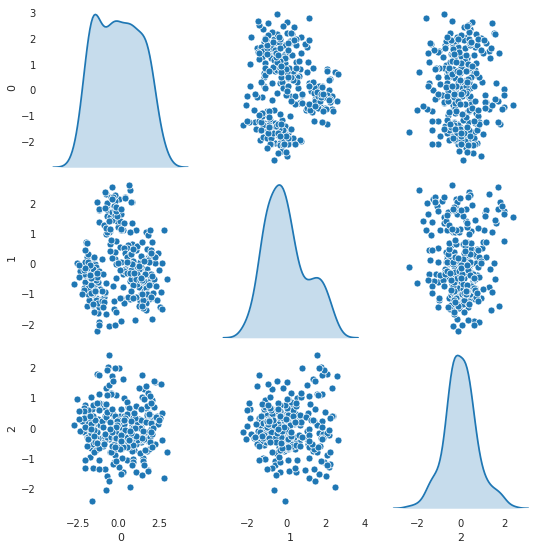

In [119]:
sns.pairplot(X_pca,diag_kind = 'kde')

#### Hyper parameter Tuning

In [120]:
target_names = ['c1 c2 c3 c4 c5 c6'.split()]

In [121]:
from sklearn.metrics import classification_report
target_names = 'c1 c2 c3 c4 c5 c6'.split()
model        = SVC()
X_train, X_test, y_train, y_test = train_test_split(X_pca,y_zscore_rem, test_size = 0.3, random_state = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          c1       0.95      0.93      0.94        41
          c2       0.65      0.87      0.74        23
          c3       0.00      0.00      0.00         2
          c4       0.00      0.00      0.00         9
          c5       1.00      0.75      0.86         4
          c6       0.75      1.00      0.86        15

    accuracy                           0.81        94
   macro avg       0.56      0.59      0.57        94
weighted avg       0.73      0.81      0.76        94



In [122]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = False) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


grid_predictions = grid.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 


{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1, gamma=0.1)
              precision    recall  f1-score   support

          cp       0.95      0.95      0.95        41
          im       0.65      0.87      0.74        23
         imS       0.00      0.00      0.00         2
         imU       0.00      0.00      0.00         9
          om       1.00      0.75      0.86         4
          pp       0.79      1.00      0.88        15

    accuracy                           0.82        94
   macro avg       0.56      0.60      0.57        94
weighted avg       0.74      0.82      0.77        94



Fillna_median -> Standard_Scaler -> Remove_corr_vars -> MinMaxScaler -> Log -> Z-Score -> Outlier_Removal -> PCA 7 - > Grid Search parameters

In [123]:
transformation            = 'Fillna_median -> Standard_Scaler -> Remove_corr_vars -> MinMaxScaler -> Log -> Z-Score -> Outlier_Removal -> PCA ' +  str(pca_dim)+ '00 - > Grid Search parameters' 
model                     = SVC(C = 100, gamma = 0.001, kernel = 'rbf')
df_result[transformation] = svm_scorer(model,X_pca,y_zscore_rem)

In [124]:
df_result_main            = pd.DataFrame(np.array(list(df_result.values()))[:,0:6], columns= ['Model','Features_shape', 'Train_Score','Test_Score','Cross_Validation_Scores','Mean_Cross_Validation_Scores'], index= df_result.keys())   
df_result_main.index.name = 'Model'  
df_result_main.style.set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,Model,Features_shape,Train_Score,Test_Score,Cross_Validation_Scores,Mean_Cross_Validation_Scores
Model,,,,,,
Fillna with mean,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna with median,SVC,"(336, 7)",0.900790,0.880950,[0.912 0.912 0.853 0.824 0.912 0.794 0.848 0.879 0.879 0.848],0.866100
Fillna_median -> Standard_Scaler,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Min_Max_Scaler,SVC,"(336, 7)",0.884920,0.892860,[0.941 0.912 0.853 0.824 0.912 0.735 0.848 0.879 0.879 0.788],0.857100
Fillna_median -> Standard_Scaler -> Remove_corr_vars,SVC,"(336, 7)",0.896830,0.892860,[0.941 0.912 0.853 0.824 0.882 0.765 0.848 0.879 0.848 0.848],0.860000
Fillna_median -> Standard_Scaler -> Remove_corr_vars -> Poly_features,SVC,"(336, 29)",0.865080,0.904760,[0.882 0.882 0.853 0.824 0.853 0.735 0.879 0.879 0.879 0.758],0.842400
Fillna_median -> Standard_Scaler -> Remove_corr_vars -> MinMaxScaler -> Log -> Z-Score -> Outlier_Removal,SVC,"(312, 7)",0.905980,0.858970,[0.938 0.906 0.839 0.903 0.839 0.806 0.871 0.871 0.839 0.806],0.861800
Fillna_median -> Standard_Scaler -> Remove_corr_vars - > PCA 6,SVC,"(336, 6)",0.884920,0.892860,[0.941 0.912 0.853 0.794 0.912 0.765 0.848 0.879 0.848 0.818],0.857000
Fillna_median -> Standard_Scaler -> Remove_corr_vars - > PCA 4,SVC,"(336, 4)",0.833330,0.880950,[0.824 0.853 0.853 0.824 0.882 0.765 0.788 0.818 0.788 0.697],0.809200


Grid search CV suggest best parameters and when we apply it on our featured data along with PCA, our score reached to .911 which is slightly better than previou results.